In [1]:
import os
from PIL import Image

from torchvision import transforms, datasets
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import shutil
import random
import copy
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from datetime import datetime

In [2]:
path = os.path.join(os.getcwd(), 'CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder')
obj_dt = datasets.ImageFolder(path, transform=transforms.ToTensor())
dataloader = DataLoader(obj_dt, batch_size=64, shuffle=False, num_workers=4)

In [3]:
mean = torch.zeros(3)
std = torch.zeros(3)

for images, _ in dataloader:
    for d in range(3):
        mean[d] += images[:, d, :, :].mean()
        std[d] += images[:, d, :, :].std()
    
mean.div_(len(obj_dt))
std.div_(len(obj_dt))

print(f'Mean : ', mean)
print(f'Std : ', std)

Mean :  tensor([0.0091, 0.0094, 0.0080])
Std :  tensor([0.0046, 0.0046, 0.0054])


In [4]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [5]:
directory = 'CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder'

img_dt = {
    'train' : datasets.ImageFolder(os.path.join(directory, 'train'), data_transforms['train']),
    'test' : datasets.ImageFolder(os.path.join(directory, 'test'), data_transforms['test']),
    'val' : datasets.ImageFolder(os.path.join(directory, 'val'), data_transforms['val'])
}

dataloaders = {
    'train' : DataLoader(img_dt['train'], batch_size=16, shuffle=True, num_workers=2),
    'test' : DataLoader(img_dt['test'], batch_size=16, shuffle=True, num_workers=2),
    'val' : DataLoader(img_dt['val'], batch_size=16, shuffle=True, num_workers=2)
}

dt_sizes = {x: len(img_dt[x]) for x in ['train', 'test', 'val']}
class_names = img_dt['train'].classes

## Modelling Code

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class EarlyStopping :
    def __init__(self, patience = 7, min_delta = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state = None

    def __call__ (self, val_loss, model):
        if self.best_loss is None :
            self.best_loss = val_loss
            self.best_state = copy.deepcopy(model.state_dict())
        
        elif val_loss > self.best_loss - self.min_delta :
            self.counter += 1
            if self.counter >= self.patience :
                self.early_stop = True

        else :
            self.best_loss = val_loss
            self.best_state = copy.deepcopy(model.state_dict())
            self.counter = 0
            
        return False

In [8]:
def create_model(num_classes):
    model = models.alexnet(pretrained=True)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.6),
        nn.Linear(256 * 6 * 6, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.6),
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.6),
        nn.Linear(1024, num_classes),
    )
    return model

In [9]:
def get_class_weights(dataset):
    labels = []

    for _, label in dataset:
        labels.append(label)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    return torch.FloatTensor(class_weights)

Train func . . .

In [22]:
def train_phase(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader :
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects



In [23]:
def val_phase(model, dataloader, criterion, device) :
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader :
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects

            

In [24]:
model = create_model(num_classes=len(class_names))
model = model.to(device)

num_epochs = 10

class_weights = get_class_weights(img_dt['train']).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    # momentum=0.9,
    weight_decay=0.001,
    # nesterov=True,
)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    pct_start=0.3,
    epochs=20,
    steps_per_epoch=len(dataloaders['train'])
)

c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # TRAINING
    train_loss, train_corrects = train_phase(model, dataloaders['train'], criterion, optimizer, device)
    train_loss /= dt_sizes['train']
    train_acc = train_corrects.double() / dt_sizes['train']
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # VALIDATION
    val_loss, val_corrects = val_phase(model, dataloaders['val'], criterion, device)
    val_loss /= dt_sizes['val']
    val_acc = val_corrects.double() / dt_sizes['val']
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

Epoch 1/10
----------
Train Loss: 1.5034 Acc: 0.3640
Val Loss: 1.0013 Acc: 0.6471
Epoch 2/10
----------
Train Loss: 1.0116 Acc: 0.6103
Val Loss: 0.7758 Acc: 0.7059
Epoch 3/10
----------
Train Loss: 0.6967 Acc: 0.7408
Val Loss: 0.7420 Acc: 0.6176
Epoch 4/10
----------
Train Loss: 0.6133 Acc: 0.7739
Val Loss: 0.5116 Acc: 0.8235
Epoch 5/10
----------
Train Loss: 0.4844 Acc: 0.8272
Val Loss: 0.4531 Acc: 0.8235
Epoch 6/10
----------
Train Loss: 0.4076 Acc: 0.8621
Val Loss: 0.4310 Acc: 0.8235
Epoch 7/10
----------
Train Loss: 0.3891 Acc: 0.8658
Val Loss: 0.3987 Acc: 0.8529
Epoch 8/10
----------
Train Loss: 0.3674 Acc: 0.8640
Val Loss: 0.4275 Acc: 0.7941
Epoch 9/10
----------
Train Loss: 0.3028 Acc: 0.8860
Val Loss: 0.4231 Acc: 0.7941
Epoch 10/10
----------
Train Loss: 0.3092 Acc: 0.8897
Val Loss: 0.4282 Acc: 0.7941


In [ ]:
# def train_model(model, criterion, scheduler, optimizer, num_epochs=20):

#     train_losses = []
#     val_losses = []
#     train_accs = []
#     val_accs = []

#     since = time.time()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
#     patience = 5
#     early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dt_sizes[phase]
#             epoch_acc = running_corrects.double() / dt_sizes[phase]

#             if phase == 'train':
#                 train_losses.append(epoch_loss)
#                 train_accs.append(epoch_acc)
#             else :
#                 val_losses.append(epoch_loss)
#                 val_accs.append(epoch_acc)

#             print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')

#             if phase == 'val':
#                 scheduler.step(epoch_loss)
#                 if early_stopping(epoch_loss, model):
#                     print('Early stopping')
#                     model.load_state_dict(early_stopping.best_state)
#                     return model
                
#                 if epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     best_model_wts = copy.deepcopy(model.state_dict())

#     print(f'Best val acc: {best_acc:4f}')
#     model.load_state_dict(best_model_wts)
#     return model, train_losses, val_losses, train_accs, val_accs
    

In [ ]:
# model = create_model(num_classes=len(class_names))
# model = model.to(device)

# class_weights = get_class_weights(img_dt['train']).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer = optim.SGD(
#     model.parameters(),
#     lr=0.005,
#     momentum=0.9,
#     weight_decay=0.001,
#     nesterov=True,
# )
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# scheduler = optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=0.01,
#     pct_start=0.3,
#     epochs=20,
#     steps_per_epoch=len(dataloaders['train'])
# )

# model, train_losses, val_losses, train_accs, val_accs= train_model(model, criterion, scheduler, optimizer, num_epochs=20)

c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------
train Loss : 1.7417 Acc : 0.2335
val Loss : 1.3318 Acc : 0.4412
Epoch 2/20
----------


c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss : 1.3705 Acc : 0.4449
val Loss : 1.0946 Acc : 0.5294
Epoch 3/20
----------
train Loss : 1.2154 Acc : 0.5074
val Loss : 0.9702 Acc : 0.5588
Epoch 4/20
----------
train Loss : 1.0873 Acc : 0.5717
val Loss : 0.8760 Acc : 0.6176
Epoch 5/20
----------
train Loss : 1.0425 Acc : 0.5790
val Loss : 0.8317 Acc : 0.6471
Epoch 6/20
----------
train Loss : 0.9868 Acc : 0.6011
val Loss : 0.7669 Acc : 0.7353
Epoch 7/20
----------
train Loss : 0.9530 Acc : 0.6397
val Loss : 0.7575 Acc : 0.7059
Epoch 8/20
----------
train Loss : 0.8366 Acc : 0.6838
val Loss : 0.6959 Acc : 0.7353
Epoch 9/20
----------
train Loss : 0.8040 Acc : 0.6893
val Loss : 0.6632 Acc : 0.7941
Epoch 10/20
----------
train Loss : 0.7715 Acc : 0.6967
val Loss : 0.6337 Acc : 0.7941
Epoch 11/20
----------
train Loss : 0.7914 Acc : 0.6875
val Loss : 0.6065 Acc : 0.7941
Epoch 12/20
----------
train Loss : 0.7184 Acc : 0.7316
val Loss : 0.6329 Acc : 0.7059
Epoch 13/20
----------
train Loss : 0.6608 Acc : 0.7537
val Loss : 0.5877

In [26]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_save_path = f'model_alexnet_{timestamp}.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    # 'model_save_path' : model_save_path,
    'optimizer_state_dict' : optimizer.state_dict(),
    'scheduler_state_dict' : scheduler.state_dict(),
    'class_names' : class_names,
}, model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to model_alexnet_2025-05-24_14-20-09.pth


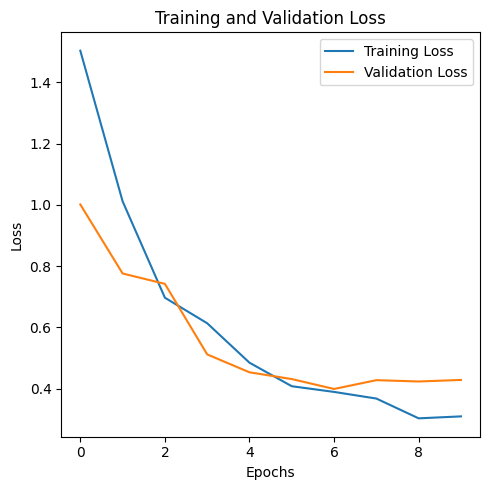

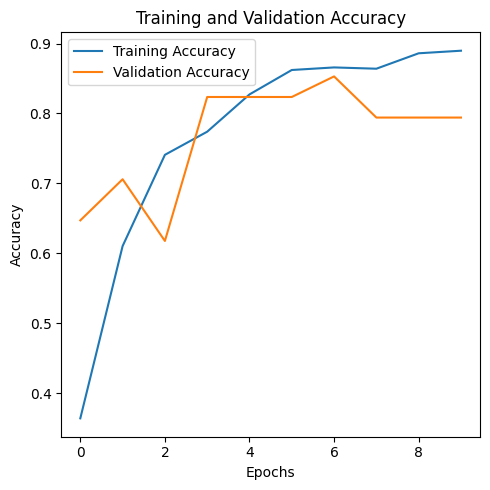

In [27]:
#membuat fungsi visualisasi untuk train_loss dan validation_loss
def plot_loss(train_loss, val_loss, save=True):
    plt.figure(figsize=(5, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()

    if save:
        # Create training_stat directory if it doesn't exist
        os.makedirs('./training_stat', exist_ok=True)

        # Save the plot with timestamp
        plt.savefig(f'./training_stat/loss_plot_model_alexnet_{timestamp}.png')

    plt.show()

def plot_accuracy(train_acc, val_acc, save=True):
    plt.figure(figsize=(5, 5))
    plt.plot([x.cpu().numpy() for x in train_acc], label='Training Accuracy') # Convert to NumPy after moving to CPU
    plt.plot([x.cpu().numpy() for x in val_acc], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.tight_layout()

    if save:
        # Create training_stat directory if it doesn't exist
        os.makedirs('./training_stat', exist_ok=True)

        # Save the plot with timestamp
        plt.savefig(f'./training_stat/accuracy_plot_model_alexnet_{timestamp}.png')

    plt.show()

# Call the functions to visualize the training history
plot_loss(train_losses, val_losses)
plot_accuracy(train_accs, val_accs)

In [28]:
def test_model(model, test_loader):
    model.eval()
    all_labels = []
    predictions = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

    print(f'Classification report : ')
    print(classification_report(all_labels, predictions, target_names=class_names))

    return accuracy, all_labels, predictions

In [29]:
test_accuracy, true_labels, pred_labels = test_model(model, dataloaders['test'])

Accuracy of the network on the test images: 91.18%
Classification report : 
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.71      0.83         7
  daun_berkerut       0.85      1.00      0.92        11
  daun_berputar       0.83      1.00      0.91         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.86      0.92         7

       accuracy                           0.91        34
      macro avg       0.94      0.91      0.92        34
   weighted avg       0.93      0.91      0.91        34



## Load model test

In [31]:
checkpoint = torch.load('model_alexnet_2025-05-24_14-20-09.pth')
print(checkpoint.keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'class_names'])


In [32]:
model = create_model(num_classes=len(class_names))
model = model.to(device)

c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# Load directly
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [34]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

In [35]:
correct = 0
total = 0

all_labels = []
predictions = []

In [36]:
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Total data to test : ' + str(total))
print(f'Total data correct : ' + str(correct))
print(f'Accuracy : {accuracy:.2f}%')

Total data to test : 34
Total data correct : 31
Accuracy : 91.18%


In [37]:
print(classification_report(all_labels, predictions, target_names=img_dt['test'].classes))

                 precision    recall  f1-score   support

    bercak_daun       1.00      0.71      0.83         7
  daun_berkerut       0.85      1.00      0.92        11
  daun_berputar       0.83      1.00      0.91         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.86      0.92         7

       accuracy                           0.91        34
      macro avg       0.94      0.91      0.92        34
   weighted avg       0.93      0.91      0.91        34



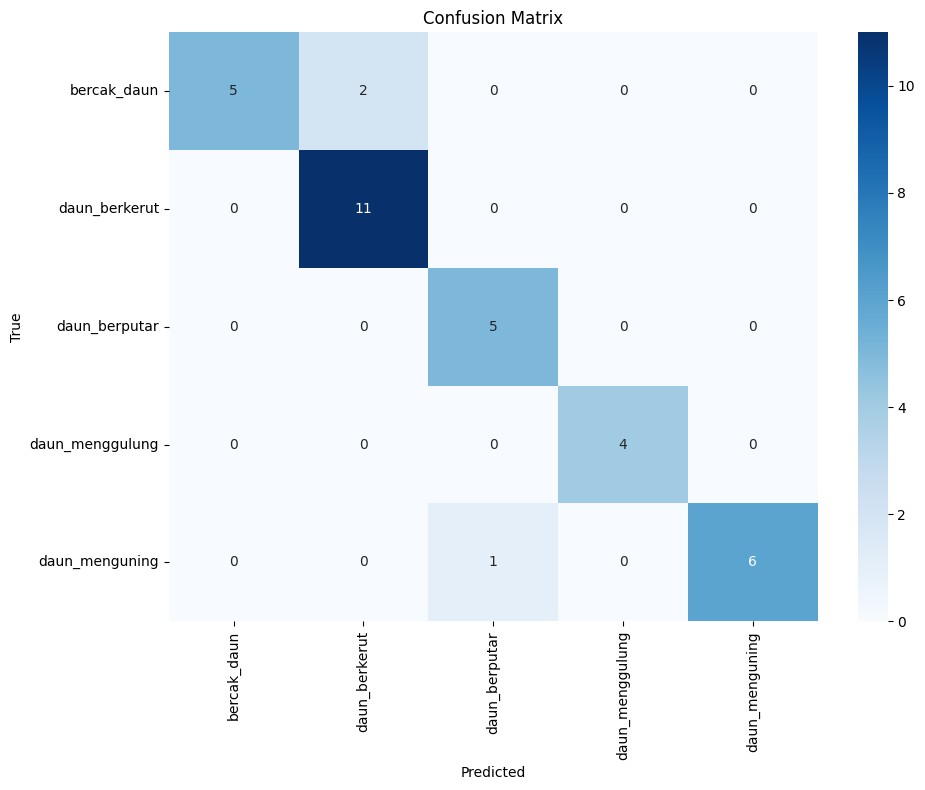

In [38]:
model_save_path = 'model_alexnet_2025-05-24_14-20-09.pth'
training_notes = model_save_path.split('.')[0]

cm = confusion_matrix(all_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()

os.makedirs('./evaluation_results', exist_ok=True)
plt.savefig(f'./evaluation_results/confusion_matrix_{training_notes}.png')
plt.show()